# train, test loading

In [1]:
print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess2/input3-2/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)

x_train_ecg = x_train[:,:,1:2]
x_test_ecg = x_test[:,:,1:2]
x_val_ecg = x_val[:,:,1:2]


print('x_train_ecg.shape:', x_train_ecg.shape)
print('x_test_ecg.shape:', x_test_ecg.shape)
print('x_val_ecg.shape:', x_val_ecg.shape)


"""
# random shuffling - train set
ids = np.arange(x_train.shape[0])
np.random.shuffle(ids)
x_train = x_train[ids]
y_train = y_train[ids]

# random shuffling - vall set
ids = np.arange(x_val.shape[0])
np.random.shuffle(ids)
x_val = x_val[ids]
y_val = y_val[ids]

# random shuffling
ids = np.arange(x_test.shape[0])
np.random.shuffle(ids)
x_test = x_test[ids]
y_test = y_test[ids]
"""                         
                          
# binary classification
y_train_bin = y_train >= 5
y_test_bin = y_test >= 5
y_val_bin = y_val >= 5

loading train...done
x_train_ecg.shape: (116619, 5000, 1)
x_test_ecg.shape: (13749, 5000, 1)
x_val_ecg.shape: (13128, 5000, 1)


# Model

## Training

In [38]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K


# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


# hyperparamters
num_nodes = [64,64,64] #, 64, 64, 64]
kernel_size = 9
pool_size = 2
BATCH_SIZE = 512
dense_node = 16
#dropout_rate = 0.2
dropout_cnn = 0.5
dropout_fc = 0.2
learning_rate = 0.1


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)

# 출력 폴더를 생성
model_name = 'model_reg_'
for num_node in num_nodes:
    model_name += '{}_'.format(num_node)
model_name += 'filtersize{}_relu_bn_maxpool{}_globalmaxpool_dropout{}_dense{}_dropout{}_batch{}_lr_{}'.format(kernel_size, pool_size, dropout_cnn, dense_node, dropout_fc, BATCH_SIZE, learning_rate)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
rootdir = 'output_ecg/'
mdir = "1D_CNN_"+model_name
save_path = rootdir+mdir

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:3"])
with strategy.scope():
    
    # build a model
    model = Sequential()
    for num_node in num_nodes:
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='valid', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(BatchNormalization())    
    model.add(GlobalMaxPool1D())
    #model.add(Flatten())
    model.add(Dropout(dropout_cnn))
    #model.add(Activation('sigmoid'))
    #model.add(Dropout(dropout_rate))
    if dense_node != 0:
        model.add(Dense(dense_node, activation='tanh'))
        model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid'))

    
    # model 학습 설정
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=["mean_absolute_error"])
    hist = model.fit(x_train_ecg, y_train/10, validation_data=(x_val_ecg,y_val), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test_ecg).flatten()

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['mean_absolute_error'], hist.history['val_mean_absolute_error']), open(save_path+'/history', 'wb'))


64-64-64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3',)
Epoch 1/100
228/228 [==============================] - ETA: 0s - loss: 0.0501 - mean_absolute_error: 0.1812
Epoch 00001: val_loss improved from inf to 18.63398, saving model to output_ecg/1D_CNN_model_reg_64_64_64_filtersize9_relu_bn_maxpool2_globalmaxpool_dropout0.5_dense16_dropout0.2_batch512_lr_0.1/weights.hdf5
228/228 [==============================] - 26s 115ms/step - loss: 0.0501 - mean_absolute_error: 0.1812 - val_loss: 18.6340 - val_mean_absolute_error: 3.6122
Epoch 2/100
228/228 [==============================] - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.1481
Epoch 00002: val_loss improved from 18.63398 to 18.56722, saving model to output_ecg/1D_CNN_model_reg_64_64_64_filtersize9_relu_bn_maxpool2_globalmaxpool_dropout0.5_dense16_dropout0.2_batch512_lr_0.1/weights.hdf5
228/228 [==============================] - 24s 107ms/step - loss: 0.0343 - mean_absolute_error:

## Model Evaluation

In [42]:
from sklearn.metrics import roc_curve, auc, r2_score, mean_absolute_error
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
#model_y = np.where(y_pred<0.5,0,1)
#print('test set accuracy:{:.2f}'.format(np.mean(model_y==y_test_bin)))

### Regression
# Model MSE of test set
#mse_val = K.eval(losses.mean_squared_error(y_test, y_pred))
model_err = metrics.RootMeanSquaredError()
model_err.update_state(y_test, y_pred)
rmse_val = model_err.result().numpy()
mae_val = mean_absolute_error(y_test, y_pred)
acc_val = np.mean((y_pred*10>=5)==y_test_bin)
print('test set mse:{:.2f}'.format(rmse_val))
print('test set accuracy:{:.2f}'.format(acc_val))
print('test set mae:{:.2f}'.format(mae_val))

# Model AUROC
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

# Model R_square
#print('test set R2:', r2_score(y_test, y_pred*10))


# Adding evaluation results to file name
# classification
os.rename(save_path,rootdir+'auc{:.4f}_mae{:.4f}_mse{:.4f}_'.format(roc_auc,mae_val,rmse_val)+mdir )

# regression
#os.rename(save_path, "output/auc{:.4f}_1D_CNN_{}rmse{:.4f}_acc{:.2f}".format(roc_auc, model_name, rmse_val,acc_val))


# plotting roc
plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

test set mse:4.16
test set accuracy:0.66
test set mae:3.45
test set auroc: 0.6780628556891237


FileNotFoundError: [Errno 2] No such file or directory: 'output_ecg/1D_CNN_model_reg_64_64_64_filtersize9_relu_bn_maxpool2_globalmaxpool_dropout0.5_dense16_dropout0.2_batch512_lr_0.1' -> 'output_ecg/auc0.6781_mae3.4522_mse4.1650_1D_CNN_model_reg_64_64_64_filtersize9_relu_bn_maxpool2_globalmaxpool_dropout0.5_dense16_dropout0.2_batch512_lr_0.1'

## Model history plot
- training curve

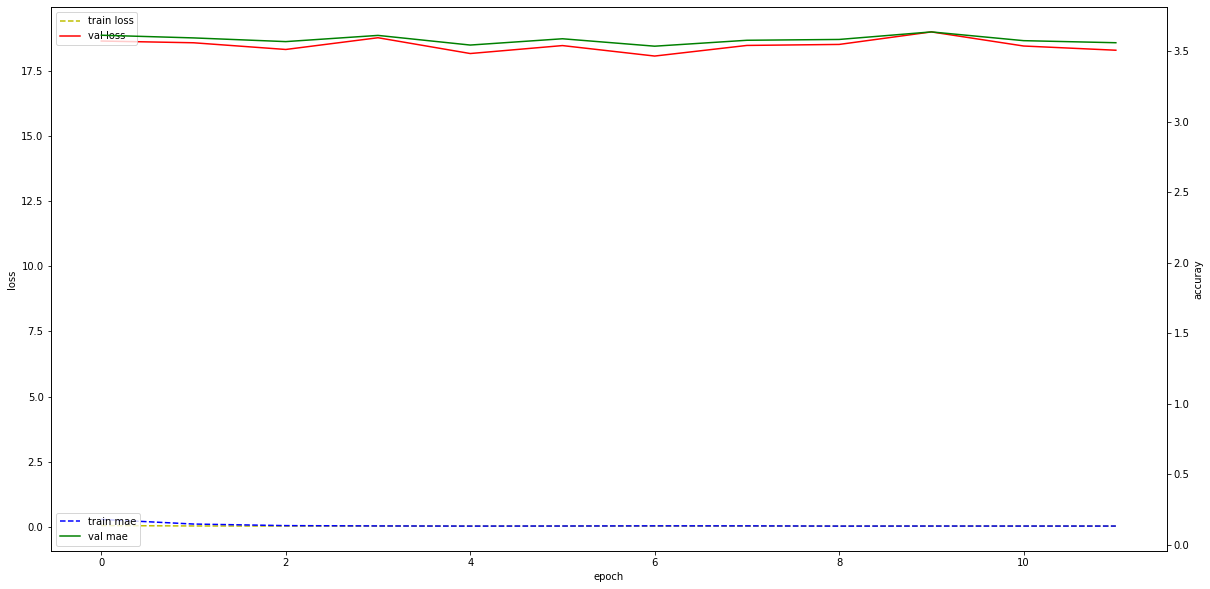

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
#acc_ax.plot(hist.history[auc_key], 'b', linestyle='dashed',label='train auc')
#acc_ax.plot(hist.history['val_'+auc_key], 'g', label='val auc')



loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Model summary

In [41]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 4992, 64)          640       
_________________________________________________________________
batch_normalization_20 (Batc (None, 4992, 64)          256       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 2496, 64)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 2488, 64)          36928     
_________________________________________________________________
batch_normalization_21 (Batc (None, 2488, 64)          256       
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 1244, 64)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1236, 64)        